**Étude du matériau Na2O**

In [1]:
from mp_api.client import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter
import numpy as np
import matplotlib.pyplot as plt

mp_key = "bZpoHPJcxLjUBeUjBLrNEUZxmaqm9yiW"
mp_id = "mp-2352"

with MPRester(mp_key) as m:
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Bande interdite

La largeur de la bande interdite est de: 1.8736000000000002 eV
La bande interdite de ce matériau est indirect
La transistion est en: (0.109,0.109,0.219)-\Gamma


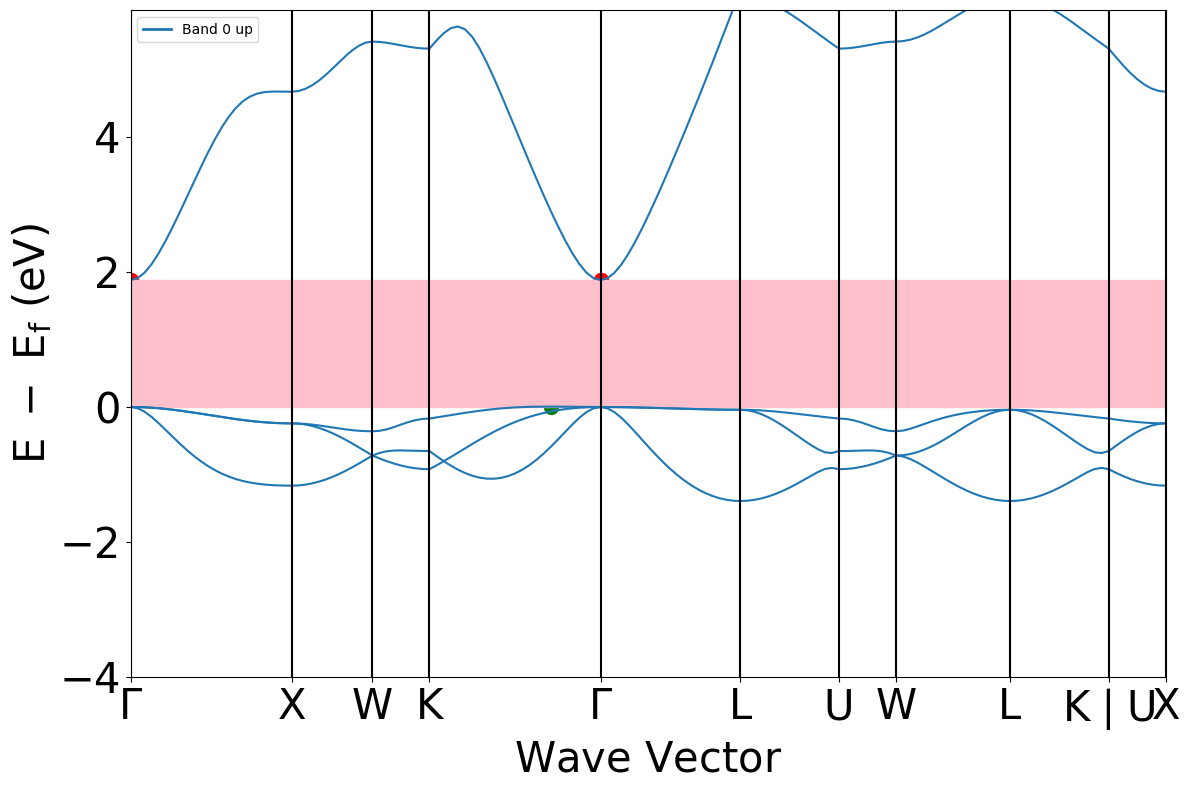

In [2]:
band_gap = el_bs.get_band_gap()
plot_bs = BSPlotter(el_bs) 

data = plot_bs.bs_plot_data()
energy = band_gap.get('energy')
distance = data.get('ticks').get('distance')

plot_bs.get_plot(vbm_cbm_marker=True)
plt.fill_between(np.linspace(distance[0], distance[-1], 2), 0, energy, color = "pink")



print("La largeur de la bande interdite est de:", band_gap["energy"],"eV")
if band_gap["direct"] is True:
    print("La bande interdite de ce matériau est direct")
if band_gap["direct"] is False:
    print("La bande interdite de ce matériau est indirect")
print("La transistion est en:", band_gap["transition"])

# Direction de dispertion

**1) Première bande de conduction**

In [3]:
cbm = el_bs.get_cbm()
print(cbm["band_index"])

defaultdict(<class 'list'>, {<Spin.up: 1>: [10]})


La bande 10 est la première bande de conduction.

**2) Dernière bande de valence**

In [4]:
vbm = el_bs.get_vbm()
print(vbm["band_index"])

defaultdict(<class 'list'>, {<Spin.up: 1>: [9]})


La bande 9 est donc la dernière bande de valence.

**3) Calculs des directions**

In [5]:
distances = data['distances']
energy = data['energy']

Valence = [] 
Conduction = []

for i in range(len(distances)):
    dx = distances[i][0]-distances[i][-1]
    
    dy_Valence = energy['1'][i][9][0]-energy['1'][i][9][-1] 
    dy_Conduction = energy['1'][i][10][0]-energy['1'][i][10][-1]
    
    slope_Valence = abs(dy_Valence/dx)
    slope_Conduction = abs(dy_Conduction/dx)
    
    Conduction.append(slope_Conduction)
    Valence.append(slope_Valence)
    
    
Valence_max = Valence.index(max(Valence))
Valence_min = Valence.index(min(Valence))
Cond_max = Conduction.index(max(Conduction))
Cond_min = Conduction.index(min(Conduction))

print("Sur la dernière bande de valence, la plus grande dispersion se trouve sur le 'chemin' d'indice", Valence_max,
      "(entre U et W) et la plus \npetite sur celui d'indice", Valence_min,"(entre Γ et L).\n")
print("Pour la première bande de conduction, la plus grande dispersion se trouve sur le 'chemin' d'indice",Cond_max,
      "(entre Γ et L) et la \nplus petite sur celui d'indice", Cond_min,"(entre W et K).\n")


Sur la dernière bande de valence, la plus grande dispersion se trouve sur le 'chemin' d'indice 6 (entre U et W) et la plus 
petite sur celui d'indice 4 (entre Γ et L).

Pour la première bande de conduction, la plus grande dispersion se trouve sur le 'chemin' d'indice 4 (entre Γ et L) et la 
plus petite sur celui d'indice 2 (entre W et K).



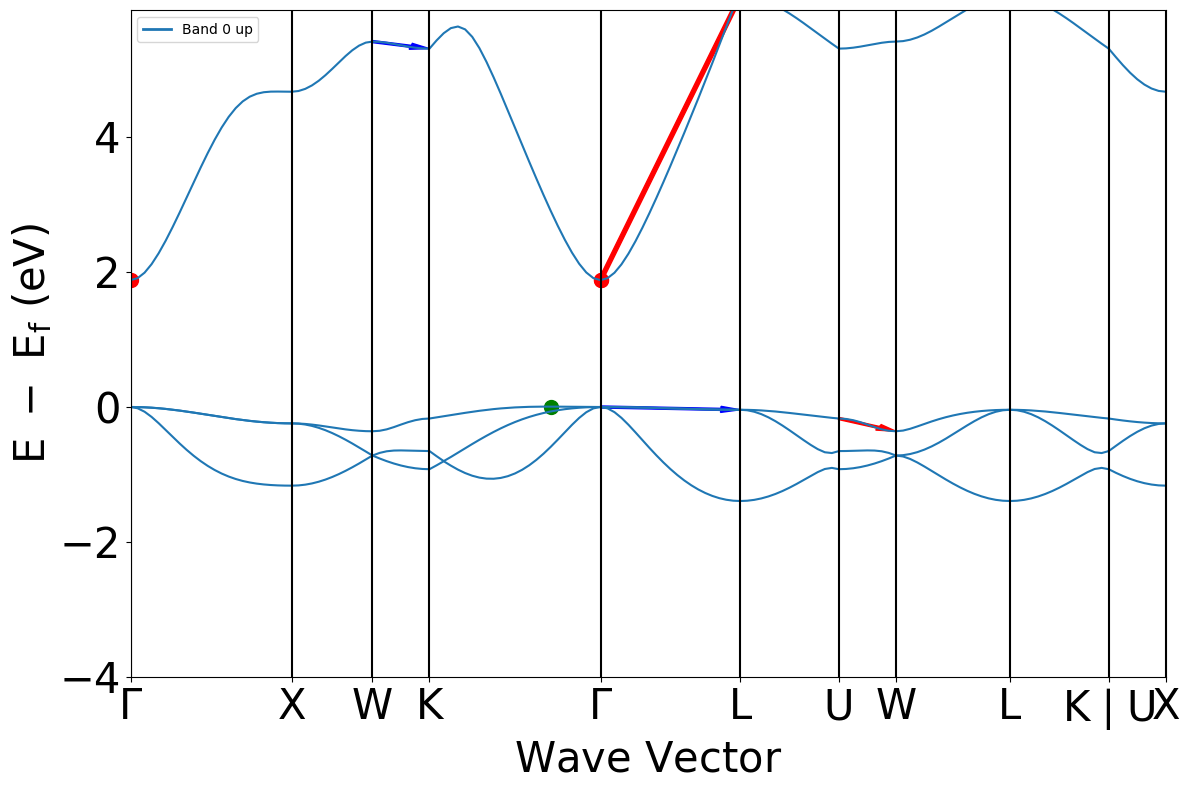

In [6]:
plot_bs.get_plot(vbm_cbm_marker=True)

# Bande de valence avec la plus petite dispertion
plt.arrow(distances[Valence_min][0], energy['1'][Valence_min][9][0], 
          distances[Valence_min][-1]-distances[Valence_min][0],
          energy['1'][Valence_min][9][-1]-energy['1'][Valence_min][9][0],
          width = 0.03,length_includes_head=True,color='blue') 

# Bande de valence avec la plus grande dispertion
plt.arrow(distances[Valence_max][0],energy['1'][Valence_max][9][0], 
          distances[Valence_max][-1]-distances[Valence_max][0],
          energy['1'][Valence_max][9][-1]-energy['1'][Valence_max][9][0],
          width = 0.03,length_includes_head=True,color='red') 

# Bande de conduction avec la plus petite dispertion
plt.arrow(distances[Cond_min][0],energy['1'][Cond_min][10][0], 
          distances[Cond_min][-1]-distances[Cond_min][0],
          energy['1'][Cond_min][10][-1]-energy['1'][Cond_min][10][0],
          width = 0.03,length_includes_head=True,color='blue')

# Bande de conduction avec la plus grande dispertion
plt.arrow(distances[Cond_max][0], energy['1'][Cond_max][10][0],
          distances[Cond_max][-1]-distances[Cond_max][0],
          energy['1'][Cond_max][10][-1]-energy['1'][Cond_max][10][0],
          width = 0.03,length_includes_head=True,color='red') 

plt.show()

# Masse effective

Pour le calcul des masses effectives en supposant une dispersion parabolique, on utilise la formule suivante : $$E(k) = \frac{ħ²k²}{2m^*}$$ 


On trouve donc la masse effective comme ceci : $$m^* = \frac{ħ²k²}{2E(k)}$$ avec $k² = k_x^2 + k_y^2 + k_z^2$

In [8]:
hbarre = 6.62607015e-34/(2*np.pi)  # J/s
eV = 1.6022e-19     # pour passer de eV à Joule
A = 1e-10

Valence_k = el_bs.get_vbm()['kpoint'].frac_coords
Cond_k = el_bs.get_cbm()['kpoint'].frac_coords

Valence_energy = el_bs.get_vbm()['energy'] 
Cond_energy = el_bs.get_cbm()['energy'] 

Valence_masse = (hbarre**2*(Valence_k[0]**2+Valence_k[1]**2+Valence_k[2]**2))/(2*Valence_energy*eV*A**2)
Cond_masse = (hbarre**2*(Cond_k[0]**2+Cond_k[1]**2+Cond_k[2]**2))/(2*Cond_energy*eV*A**2)


print("La masse effective au sommet de la dernière bande de valence est de",Valence_masse,"kg\n")
print("La masse effective à la base de la première bande de conduction est de",Cond_masse,"kg\n")


La masse effective au sommet de la dernière bande de valence est de 4.110743297576608e-31 kg

La masse effective à la base de la première bande de conduction est de 0.0 kg

